# Анализ влияния индекса страха и жадности (Fear & Greed Index) на цену криптовалюты Bitcoin

# Содержание

* [1. Описание задачи](#0)
* [2. Установка инструментов](#1)
    * [2.1 Список пакетов Python](#1-1)
    * [2.2 Импорт пакетов](#1-2)
* [3. Загрузка данных](#2)
* [4. Предварительная обработка данных](#3)
    * [4.1 Объединение данных в один DataFrame](#3-1)
* [5. Первичный анализ](#4)
    * [5.1 Анализ распределения цены и индекса](#4-1)
    * [5.2 Оценка корреляции](#4-2)
    * [5.3 Промежуточные выводы](#4-3)
* [6. Анализ первичных результатов. Проверка гипотезы](#5)
    * [6.1 Показатель рентабельности инвестиций ROI](#5-1)
    * [6.2 Расчет показателя](#5-2)
    * [6.3 Анализ результатов](#5-3)
* [7. Выводы](#6)



<a id='0'></a>
# Часть 1. Описание задачи

В данном проекте попробуем оценить влияние достаточно интересного индекса страха и жадности (Fear & Greed Index) на движение цены самой популярной криптовалюты Bitcoin. Оценим корреляцию и узнаем, можно ли полагаться на индекс для среднесрочных инвестиций.

Для чего же вообще измеряется индекс страха и жадности? Поведение криптовалютного рынка очень эмоционально. Люди склонны к жадности, когда рынок растёт, что приводит к FOMO (страху упустить возможность). Кроме того, люди часто продают свои активы в иррациональной реакции на увиденные низкие показатели. Здесь есть два простых предположения:

* Чрезмерный страх может быть признаком того, что инвесторы слишком обеспокоены. Это может быть возможностью для покупки.
* Когда инвесторы становятся слишком жадными, это означает, что рынок ожидает коррекция.

Показатель индекса варьируется от 0 до 100. Ноль означает «Чрезмерный страх», а 100 — «Чрезмерная жадность».

Индекс строится из нескольких состовляющих:
* **Волатильность (25 %)**
Измерение текущей волатильности и максимальные просадки биткоина и сравниваем их с соответствующими средними значениями за последние 30 и 90 дней.

* **Импульс/Объем рынка (25 %)**
Измерение текущего объема и импульса рынка (опять же, в сравнении со средними значениями за последние 30/90 дней) и объединение эти двух показателей. Как правило, когда наблюдаются высокие объемы покупок на позитивном рынке ежедневно, делается вывод, что рынок ведет себя чрезмерно жадно/слишком оптимистично.

* **Социальные сети (15 %)**
Собираются и подсчитываюся посты по различным хэштегам в соцсетях, и проверяются, как быстро и сколько взаимодействий они получают за определенные промежутки времени. Необычно высокий уровень взаимодействия приводит к росту общественного интереса, что может соответствовать жадному поведению рынка.

* **Опросы (15%)**
Проведение еженедельных опросов людей, как они видят рынок. По ним получают представления о настроениях групп инвесторов.

* **Доминирование (10%)**
Доминирование монеты отражает долю рыночной капитализации всего криптовалютного рынка. В частности, что касается Биткоина, рост его доминирования вызван страхом перед слишком спекулятивными инвестициями в альткоины и, следовательно, сокращением, поскольку Биткоин все больше становится безопасным убежищем для криптовалют. Когда доминирование Биткоина сокращается, люди становятся более жадными, инвестируя в более рискованные альткоины и мечтая о своем шансе в следующем крупном бычьем ралли. Анализируя доминирование другой монеты, помимо Биткоина, можно утверждать обратное, поскольку больший интерес к альткоину может свидетельствовать о бычьем/жадном поведении по отношению к этой конкретной монете.

* **Тренды (10%)**
Собираются  и анализируются данные Google Trends по различным поисковым запросам, связанным с Биткоином, особенно изменение объемов поиска, а также рекомендуемые другие популярные в настоящее время запросы. Например, если мы проверим Google Trends по запросу «Биткоин», мы не получим много информации из объема поиска. Однако в настоящее время мы можем видеть рост запроса «манипулирование ценой биткоина» на +1550% в блоке связанных поисковых запросов. Это явный признак страха на рынке.

Будем анализировать временной ряд за 2024 и неполный 2025 год

Данные, которые мы будем использовать, получены из API криптовалютной биржи Binance и API Alternative.me. Данные содержат цены открытия, максимальные, минимальные и закрытия, объем торгов, а так же значение показателя индекса.

<a id='1'></a>
# Часть 2. Загрузка пакетов

<a id='1-1'></a>
## 2.1. Перечень пакетов, которые мы будем использовать в данном отчете
* pandas;
* numpy;
* scipy.stats;
* matplotlib;
* requests;
* pybit - API биржи Binance.

<a id='1-2'></a>
## 2.2. Импорт пакетов

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# from dotenv import load_dotenv
from datetime import datetime, timedelta
from pybit.unified_trading import HTTP
from scipy import stats
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator


%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# load_dotenv()

<a id='2'></a>
# Часть 3. Загрузка данных

Наши данные будем брать из двух источников:
* **API биржи Binance** очень функционален и предоставляет много различных данных о криптовалютах. В данном случае нас интересуют данные OHLC (данные цены) по криптовалюте Bitcoin.

* **API Alternative.me** предоставляет данные по индексу страха и жадности


In [12]:
# Создадим экземпляр класса API биржи и зададим нужные глобальные переменные для работы с другими источниками данных
session = HTTP(testnet=False)
# URL_1 = 'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical'
# API_KEY = os.getenv('API_SECRET')
URL = 'https://api.alternative.me/fng/'
SYMBOL = 'BTCUSDT'
START_DATE_24 = '2024-01-01'
END_DATE_24 = '2025-01-02'
START_DATE_25 = '2025-01-01'
END_DATE_25 = '2025-12-17'


# Загружаем данные
def extract_data(session=session, date_start=None, date_end=None, url=URL, symbol=SYMBOL):
    ''' Функция получает данные цен с биржи и данные индекса
    Необходимо указывать конечную дату на 1 день больше, так как данные по закрытию 
    приходят в 03:00 АМ на сл.день
    Параметры:
    - session: объект сессии API Binance
    - date_start: начальная дата (str в формате 'YYYY-MM-DD')
    - date_end: конечная дата (str в формате 'YYYY-MM-DD')
    - url: URL API 
    - symbol: тикер актива'''

    # Переводим даты в timestamp(ms) для корректного получения данных с биржи
    start = int(datetime.strptime(date_start, '%Y-%m-%d').timestamp() * 1000)
    end = int(datetime.strptime(date_end, '%Y-%m-%d').timestamp() * 1000)

    response_exchange = session.get_kline(
        category='inverse',
        symbol=symbol,
        interval='D',
        start=start,
        end=end,
        limit=367
    )

    params = {
        'limit': 0
    }
    response_index = requests.get(url, params=params).json()

    return response_exchange['result']['list'], response_index['data']

data_2025, index_2025 = extract_data(date_start=START_DATE_25, date_end=END_DATE_25)
data_2024, index_2024 = extract_data(date_start=START_DATE_24, date_end=END_DATE_24)

In [13]:
# Посмотрим на полученные данные
data_2024[:2], index_2024[:2]

([['1735689600000',
   '93530',
   '95158.4',
   '92840',
   '94564.6',
   '46830.37',
   '4399935460.3038'],
  ['1735603200000',
   '92739.3',
   '96322.1',
   '91981.4',
   '93530',
   '98560.554',
   '9282689586.2034']],
 [{'value': '14',
   'value_classification': 'Extreme Fear',
   'timestamp': '1770163200',
   'time_until_update': '33439'},
  {'value': '17',
   'value_classification': 'Extreme Fear',
   'timestamp': '1770076800'}])

<a id='3'></a>
# Часть 4. Предварительная обработка данных

<a id='3-1'></a>
## Часть 4.1. Объединение данных
Для дальнейшей работы объединим полученные по API данные в один DataFrame

In [4]:
# Предварительная обработка данных
def transform_data(price_data: list, index_data: list):
    '''
    Преобразует и объединяет данные о ценах актива и индексные данные в структурированный DataFrame
    Параметры:
    - price_data: List 
        Массив данных цены актива
    - index_data: List 
        Массив данных по индексу
    '''
    df = pd.DataFrame(price_data, columns=['date', 'open', 'high', 'low', 'close', 'vol', 'turnover'])
    df = df.iloc[:, :6]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, unit='ms')
    df = df.astype('float')

    df2 = pd.DataFrame({
        'date': [i['timestamp'] for i in index_data],
        'index': [i['value'] for i in index_data]
    })
    df2.set_index('date', inplace=True)
    df2.index = pd.to_datetime(df2.index, unit='s')
    df2 = df2.astype('int')

    df3 = pd.concat([df, df2], axis=1, join='inner')
    df3.sort_index(inplace=True)

    # Добавим скользящую среднюю и скользящую медиану за 30Д
    rolling = df3['close'].rolling(30, min_periods=1)
    df3['roll_mean'] = rolling.mean().round(3)
    df3['roll_median'] = rolling.median()

    return df, df2, df3

price, index, total_2025 = transform_data(data_2025, index_2025)
price, index, total_2024 = transform_data(data_2024, index_2024)

C:\Users\deadm\AppData\Local\Temp\ipykernel_13464\3351371578.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df.index = pd.to_datetime(df.index, unit='ms')
C:\Users\deadm\AppData\Local\Temp\ipykernel_13464\3351371578.py:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df2.index = pd.to_datetime(df2.index, unit='s')
C:\Users\deadm\AppData\Local\Temp\ipykernel_13464\3351371578.py:14: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In

In [5]:
# Проверим, есть ли в полученном датафрейме NaN значения
print(f'''
2024 год: \n{total_2024.isnull().sum()}
''')
print(f'''
2025 год: \n{total_2025.isnull().sum()}''')


2024 год: 
open           0
high           0
low            0
close          0
vol            0
index          0
roll_mean      0
roll_median    0
dtype: int64


2025 год: 
open           0
high           0
low            0
close          0
vol            0
index          0
roll_mean      0
roll_median    0
dtype: int64


<a id='4'></a>
# Часть 5. Первичный анализ
<a id='4-1'></a>
## Часть 5.1. Анализ распределения цены и индекса
Для начала, чтобы понять, какой коэфициент корреляции мы будем использовать, взглянем на распределения наших данных.

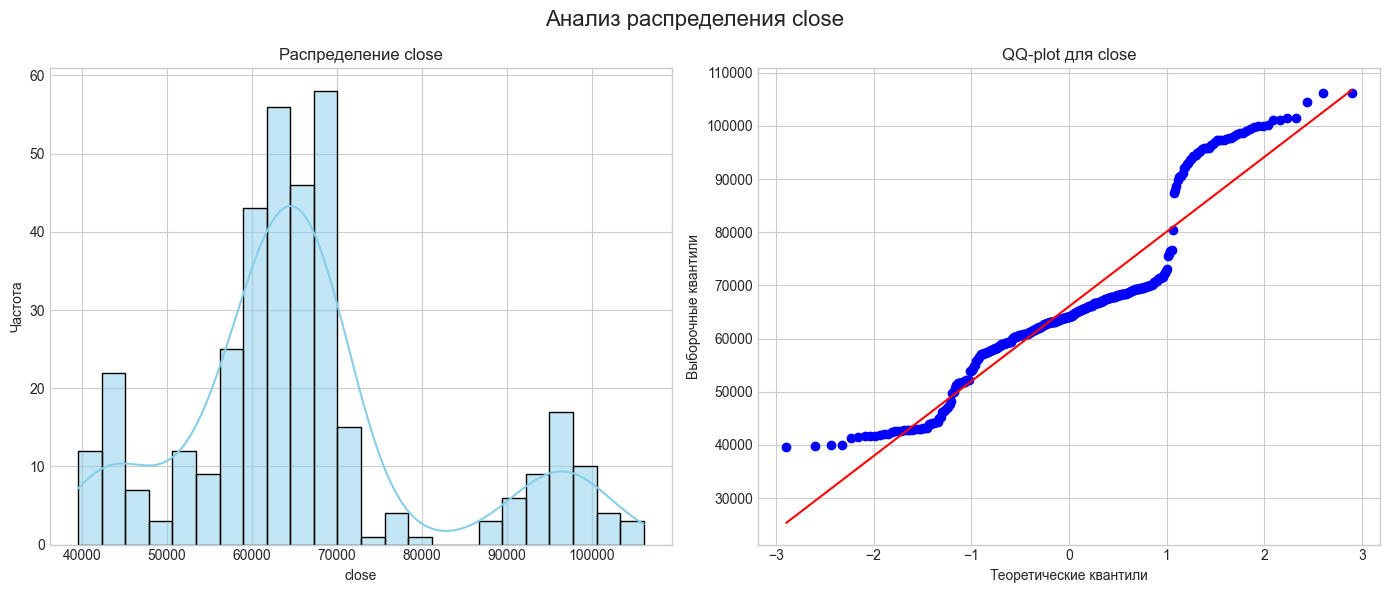

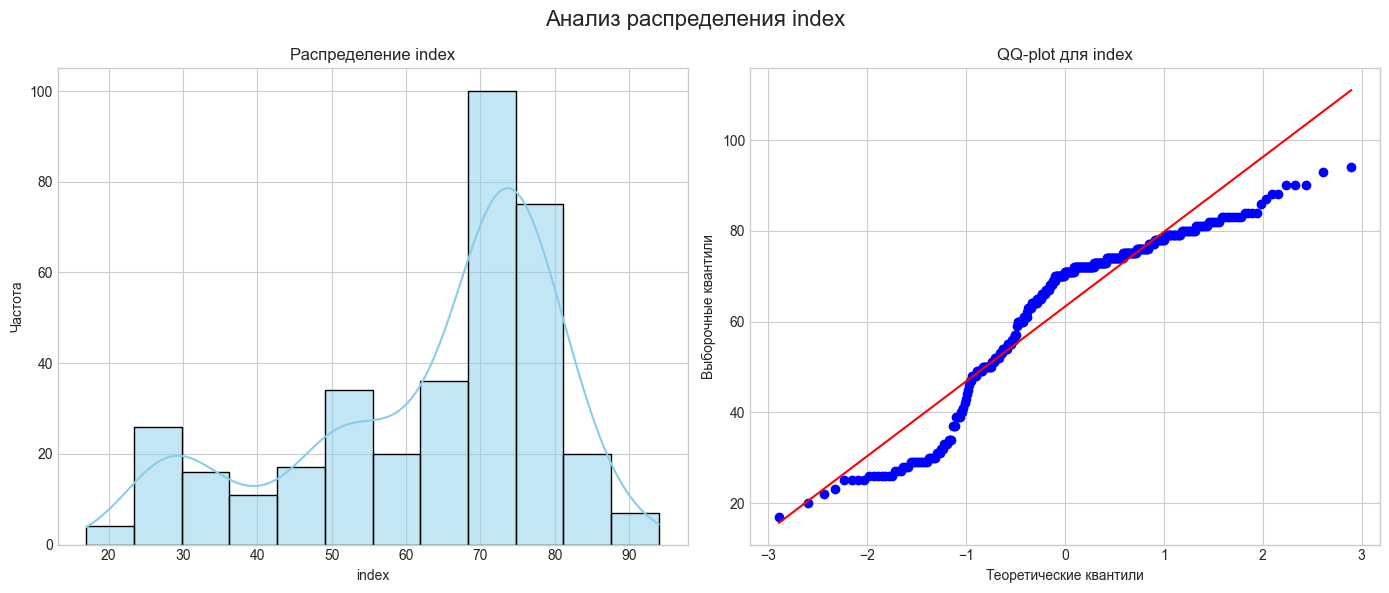

In [6]:
# Посмотрим на распределение наших целевых данных за 2024 год (цены закрытия дня и индекса)

def plot_dist(data: pd.DataFrame, column_name):
    '''
    Функция для построения гистограммы и QQ-plot
    Параметры:
    data: pd.DataFrame
        Входной датасет
    column_name: str
        название столбца для построения
    '''
    # Проверка на налчие данных 
    if column_name not in data.columns:
        raise ValueError(f"столбец {column_name} не найден в данных")
    
    # Создаем фигуру
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Гистограмма
    sns.histplot(
        data[column_name],
        kde=True,
        ax=axes[0],
        color='skyblue',
        edgecolor='black'
    )
    axes[0].set_title(f'Распределение {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Частота')

    # QQ-plot
    stats.probplot(
        data[column_name],
        plot=axes[1]
    )
    axes[1].set_title(f'QQ-plot для {column_name}')
    axes[1].set_xlabel('Теоретические квантили')
    axes[1].set_ylabel('Выборочные квантили')

    # Настройки
    plt.suptitle(f"Анализ распределения {column_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Взгялнем на наши данные
close_plot_24 = plot_dist(total_2024, 'close')
index_plot_24 = plot_dist(total_2024, 'index')

На основе данных графика можно сделать вывод, что значения close, index не подчиняются нормальному закону распределения, имеют выраженные выбросы. 

Учитывая это, будем использовать коэффициент корреляции Спирмена вместо Пирсона, т.к. он не требует нормального распределения и устойчив к выбросам.

<a id='4-2'></a>
## Часть 5.2. Оценка корреляции
Проверим статестическую гипотезу о наличии связи между переменными close и index с помощью коэффициента ранговой корреляции Спирмена.

Формулировка гипотез:
* **Нулевая гипотеза (H0):**
    Между close и index нет связи, коэф.корреляции равен 0.
* **Альтернативная гипотеза (H1):**
    Между close и index есть связь, коэф.корреляции не равен 0.

Уровень занчимости ɑ возьмем равным 0.05.

In [7]:
# Рассчитаем на наших данных коэффициент корреляции и найдем p-value
def cal_stat_sper(df: pd.DataFrame):
    '''
    Функция рассчитывает коэффицент корреляция Спирмена и p-value
    '''
    rho, p_value = stats.spearmanr(df['close'], df['index'])
    print(f"Итого за {df.index[0].strftime('%Y')} г.")
    print(f"Коэф Спирмена: (p): {rho:.3f}")
    print(f"p-value: {p_value}\n")

stat_2024 = cal_stat_sper(total_2024)
stat_2025 = cal_stat_sper(total_2025)

Итого за 2024 г.
Коэф Спирмена: (p): 0.657
p-value: 1.2434650118816215e-46

Итого за 2025 г.
Коэф Спирмена: (p): 0.531
p-value: 8.247831449895505e-27



<a id='4-3'></a>
## Часть 5.3. Промежуточные выводы
На основе статистического теста Спирмена мы убедились в том, что у нас наблюдается умеренная положительная связь переменных в 2024 и 2025 году. При этом результат является статестически значимым, т.к вероятность получить такой коэффициент случайно при верности нулевой гипотезы практически нулевая (p-value < 0.05).

<a id='5'></a>
# Часть 6. Анализ первичных результатов. Проверка гипотезы
На основании статистического теста мы убедились в связи наших переменных. Исходя из этого, мы можем посмотреть, при каких значениях индеса происходят критические моменты в смене тренда (направления движения цены), и далее проверить какие-либо гипотезы.

Сперва построим временной ряд с нашими переменными

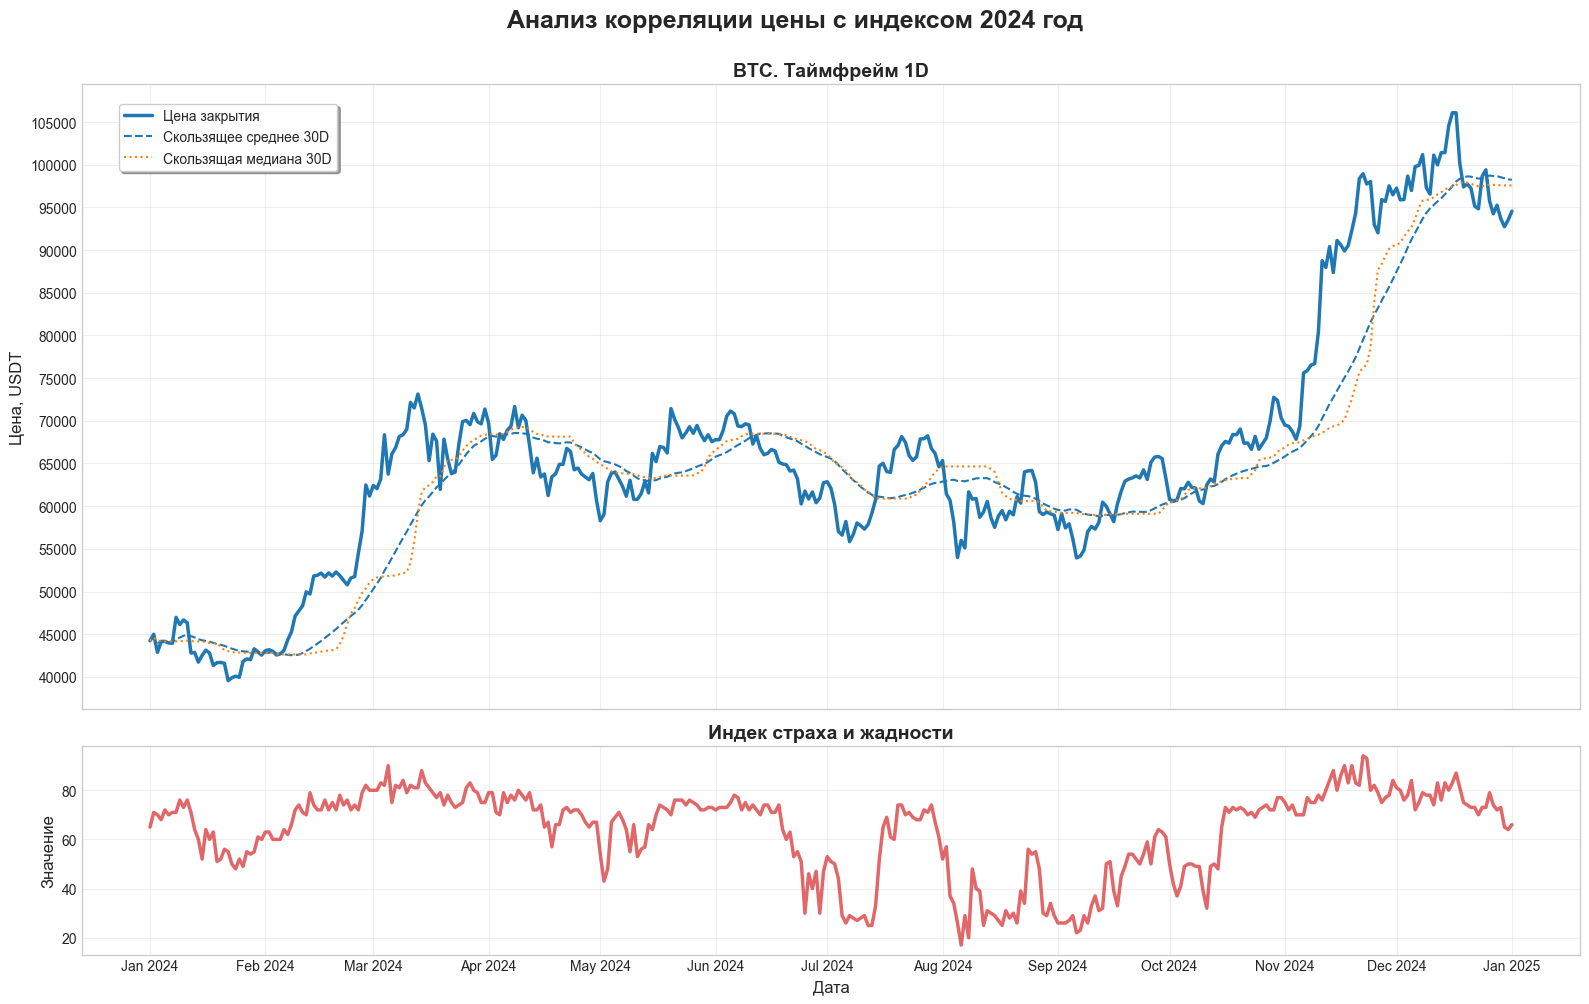

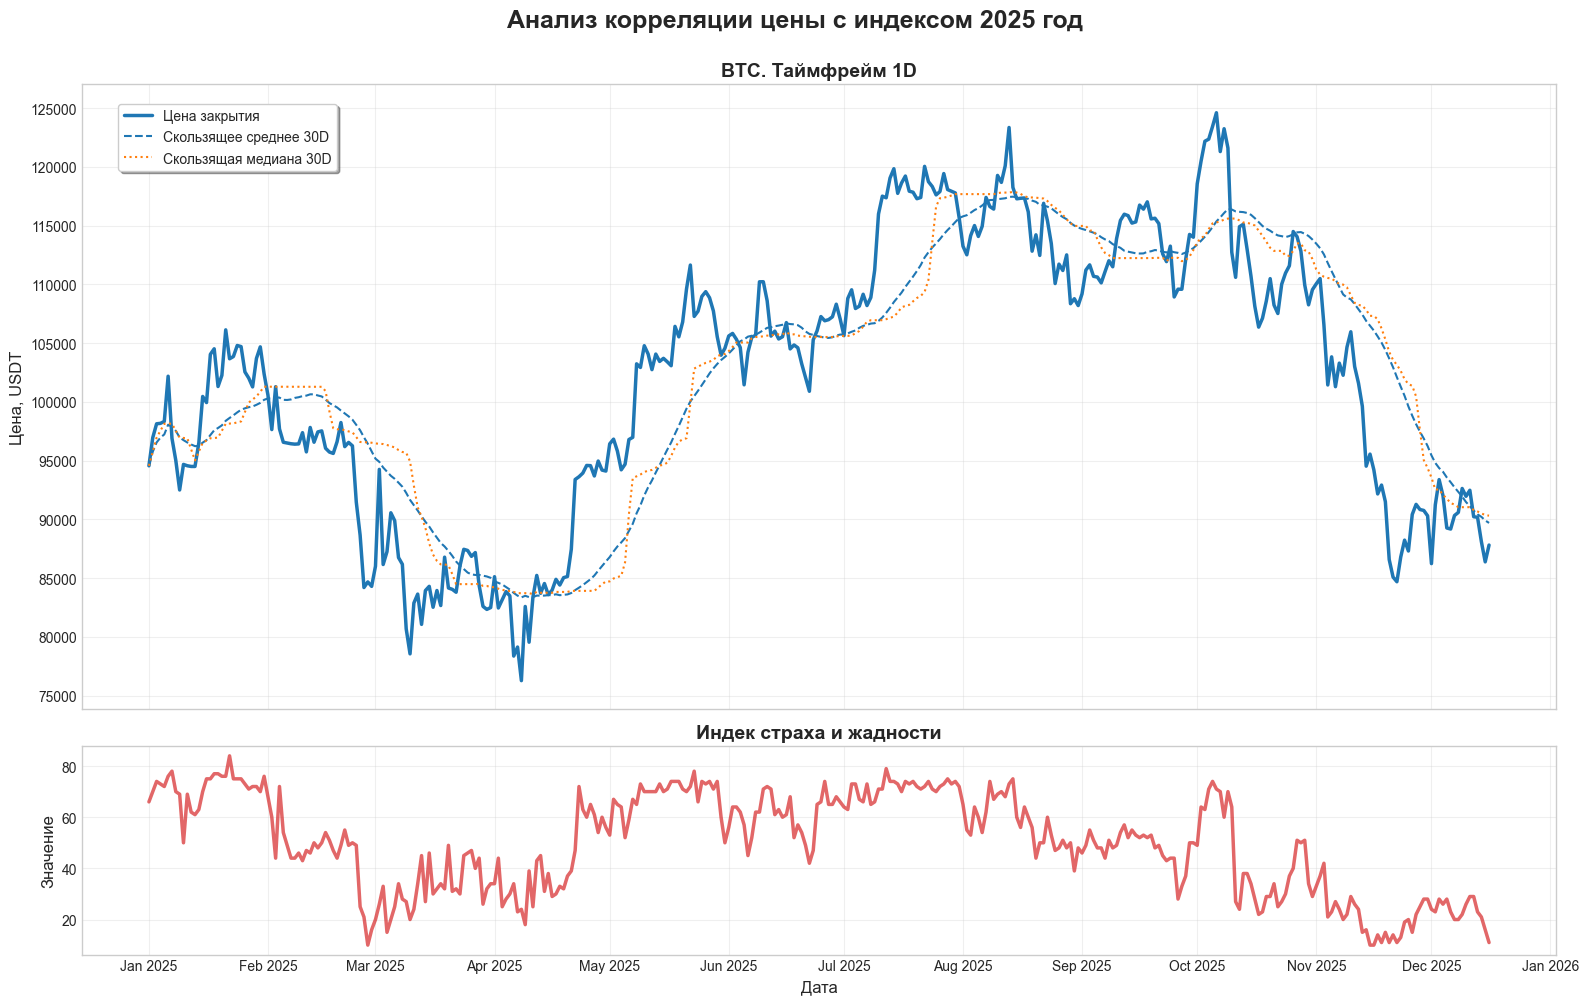

In [8]:
# Визуализируем данные
def global_plot(data: pd.DataFrame, index_lines: dict = None, periods: list = None):
    '''
    Функция строит общий график цены и индекса. Дополнительно можно 
    наложить на график горизонтальные линии и периоды
    Параметры:
    data: pd.DataFrame
        Датафрейм с даннными
    year: int
        Год временного ряда
    index_lines: dict
        Словарь линий для графика индекса
    periods: list
        Список периодов 
    '''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), 
                                   sharex=True, 
                                   gridspec_kw={'height_ratios': [3, 1]})

    # Верхний график — цена
    ax1.plot(data.close, color='#1f77b4', linewidth=2.5, 
            label='Цена закрытия')
    ax1.plot(data.roll_mean, linestyle='--', linewidth=1.5, 
            label='Скользящее среднее 30D')
    ax1.plot(data.roll_median, linestyle=':', linewidth=1.5, 
            label='Скользящая медиана 30D')
    ax1.set_title('BTC. Таймфрейм 1D', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Цена, USDT', fontsize=12)

    # Форматируем оси
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.yaxis.set_major_locator(MultipleLocator(5000))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
            ncol=1, frameon=True, fancybox=True, shadow=True)

    # Наложение периодов низкого индекса
    if periods:
        for i, period in enumerate(periods):
            ax1.plot(period.index, period['close'], color="#1fb433", 
                    linewidth=3.5, label='Индекс < 20')
            ax1.grid(True, alpha=0.3)

            # Аннотации: подпись над каждым периодом
            mid_date = period.index[len(period) // 2] # середина периода
            mid_price = period.iloc[len(period) // 2]['close']
            ax1.annotate(f'Период {i+1}',
                        xy=(mid_date, mid_price),
                        xytext=(0, 10), # смещение вверх на 10 пунктов
                        textcoords='offset points',
                        fontsize=10,
                        fontweight='bold',
                        color='#1fb433',
                        ha='center',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                alpha=0.8))

    # Нижний график — индекс
    ax2.plot(data['index'], color='#d62728', alpha=0.7, 
            linewidth=2.5, label='Индекс')
    ax2.set_title('Индек страха и жадности', fontsize=14, 
                fontweight='bold')
    ax2.set_ylabel('Значение', fontsize=12)
    ax2.set_xlabel('Дата', fontsize=12)
    
    if index_lines:
        for y, params in index_lines.items():
            ax2.axhline(
                y=y,
                color=params.get('color', 'purple'),
                linestyle=params.get('linestyle', ':'),
                linewidth=params.get('linewidth', 1.5),
                label=params.get('label', f'Уровень {y}')
            )

    ax2.grid(True, alpha=0.3)

    fig.suptitle(
        f'Анализ корреляции цены с индексом {data.index[0].strftime('%Y')} год',
        fontsize=18, fontweight='bold',
        y = 1
    )
    plt.tight_layout()
    plt.show()

total_plot_2024 = global_plot(total_2024)
total_plot_2025 = global_plot(total_2025)

Из графиков мы видим, что индекс ходит достаточно в широком диапазоне от 20 до 80 и достаотчно неплохо коррелирует с ценой, что подтвержает наш статистический тест.

Отметим на графике границы движения индекса.

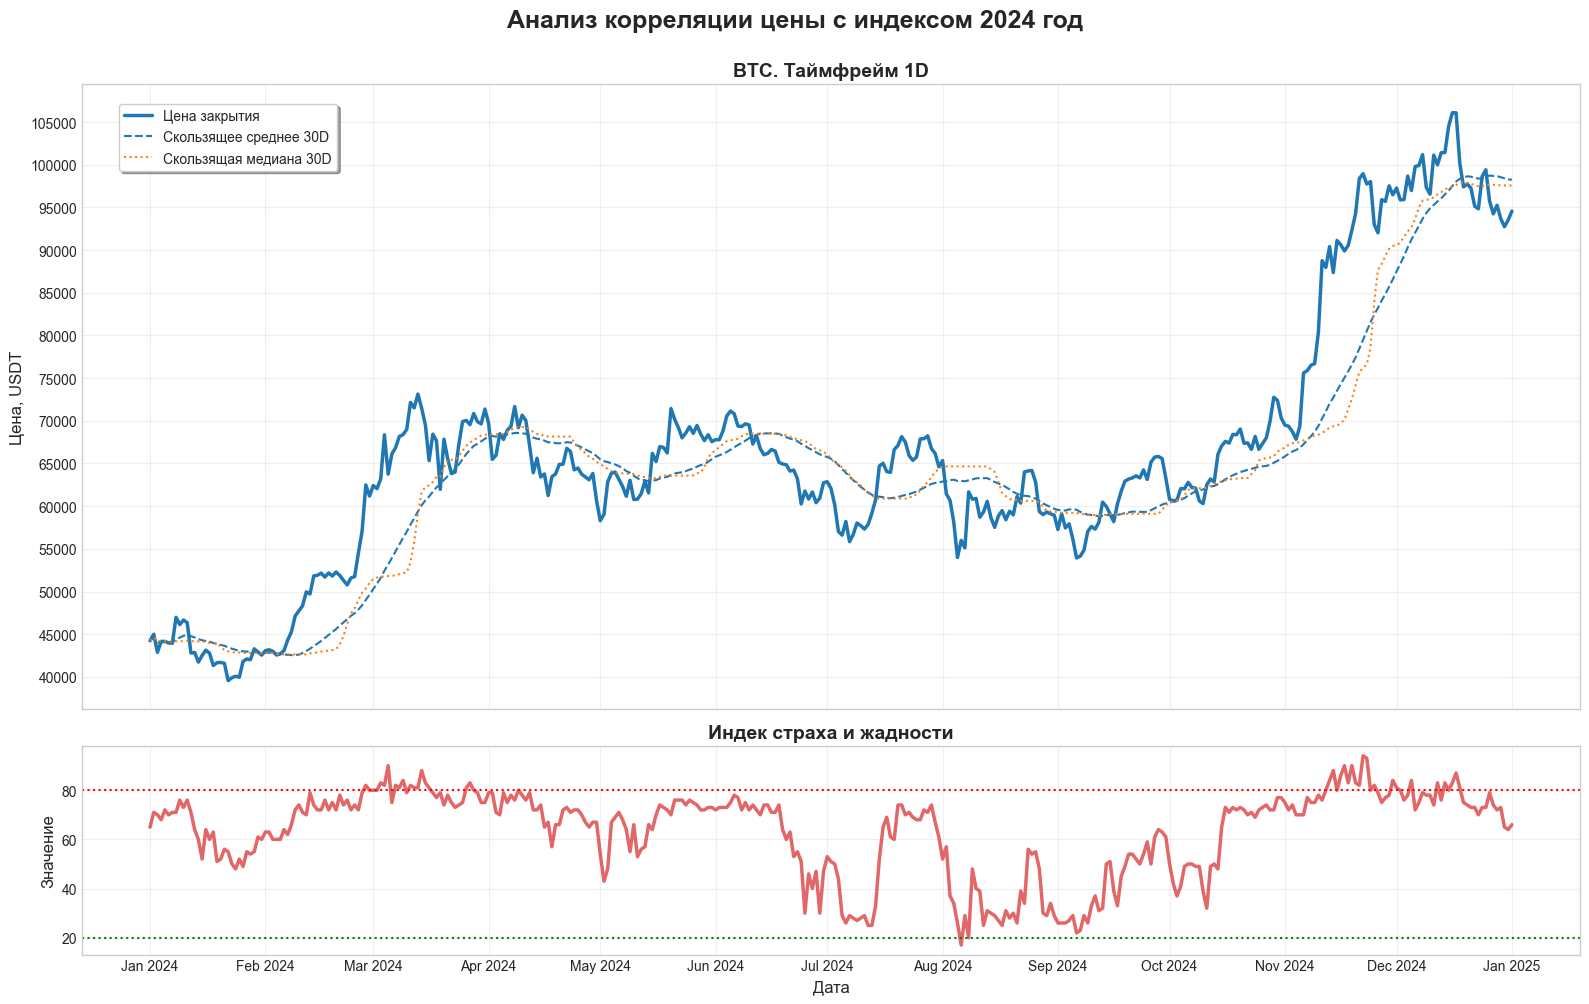

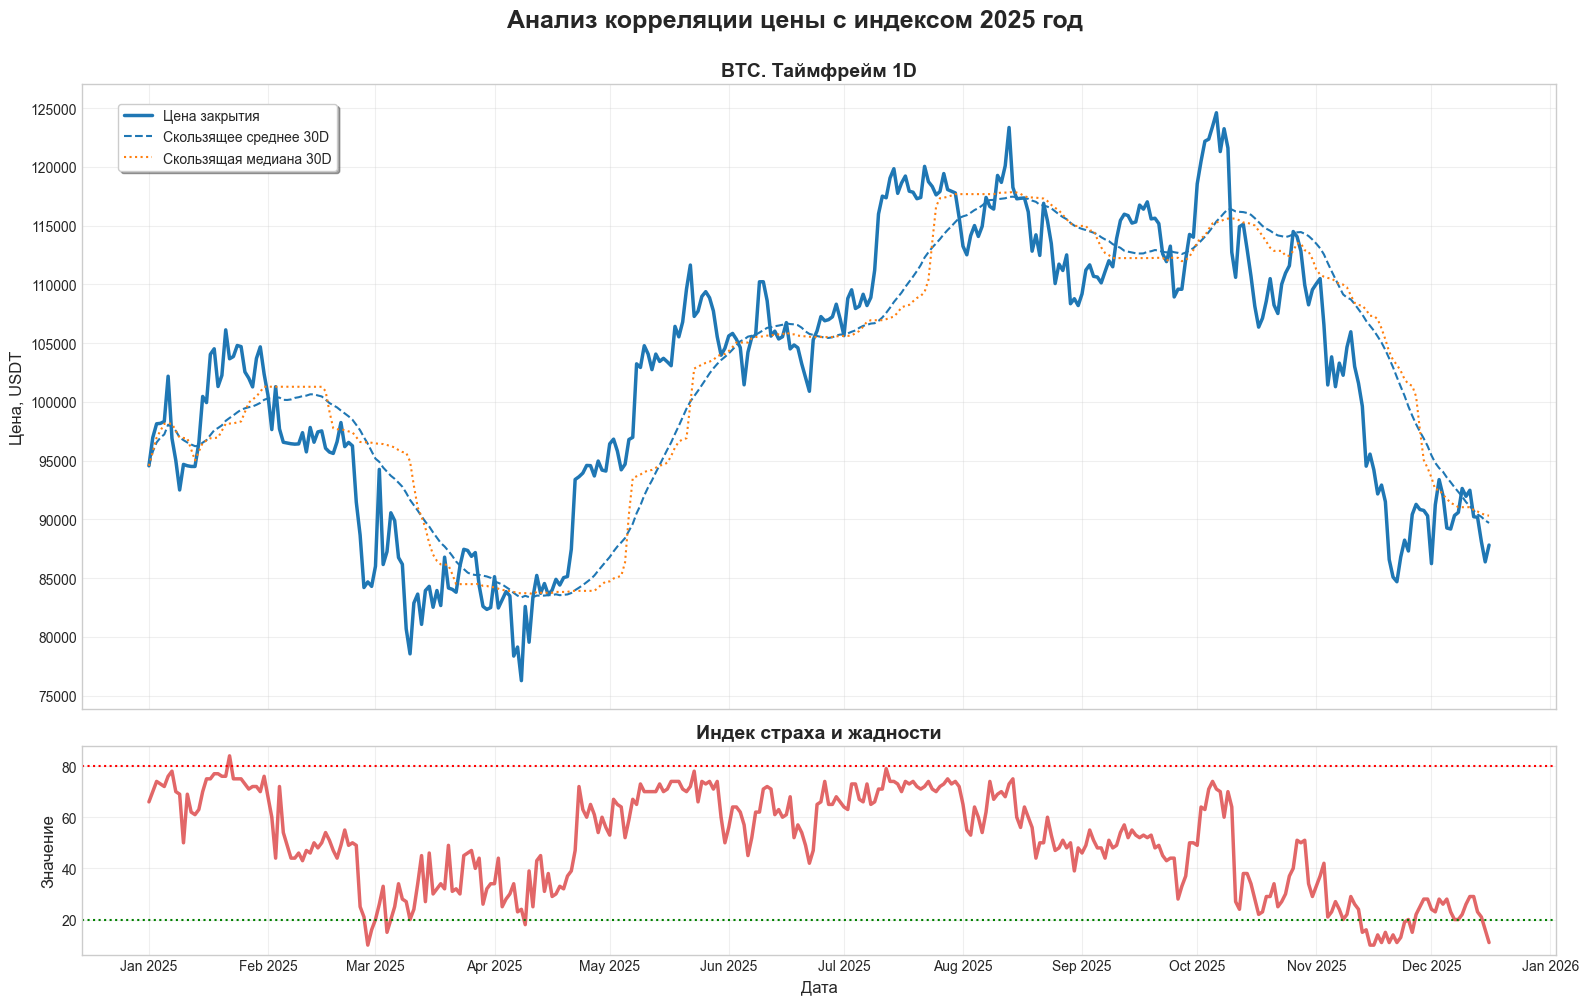

In [11]:
# Задаем параметры линий
lines = {
    80: {'color': 'red', 'linestyle': ':'},
    20: {'color': 'green', 'linestyle': ':'}
}

total_plot_2024_lines = global_plot(total_2024, index_lines=lines)
total_plot_2025_lines = global_plot(total_2025, index_lines=lines)


Теперь мы отчетливо видим наши пороговые значения индекса, а так же можем сделать вывод, что достаточно редко индекс пересекает эти границы.

Исходя из этого, мы можешь рассмотреть значения за пределами границ этих линий как аномальные значения. Выденем гипотезу, что каждый раз при достижении индекса значения $\leq 20$ цена в ближайший месяц с этого момента  не сильно менялась, т.к. участники рынка находились в экстримальном страхе и не совершали покупок актива.

Для этого сперва выберем периоды, когда индекс был $\leq 20$:

In [12]:
# Выберем пириоды низкого индекса
def find_periods(df: pd.DataFrame):
    min_index = df.loc[df['index'] < 20].sort_index()
    min_index['date_diff'] = min_index.index.diff().fillna(pd.Timedelta(days=0))

    fragments = []
    current_period = [min_index.iloc[0]]

    for i in range(1, len(min_index)):
        if min_index.iloc[i]['date_diff'] > pd.Timedelta(days=20):
            fragments.append(pd.DataFrame(current_period))
            current_period = [min_index.iloc[i]]
        else:
            current_period.append(min_index.iloc[i])
    fragments.append(pd.DataFrame(current_period))

    return fragments

periods_2025 = find_periods(total_2025)
periods_2024 = find_periods(total_2024)

# periods_2025

def print_periods(periods: list, year: int):
    print(f'Year {periods[0].index[0].strftime('%Y')}')
    for  i, period in enumerate(periods):
        print(f'period {i + 1}:')
        print(f'{period}\n')

# Взглянем на полученные периоды
print_2024 = print_periods(periods_2024, 2024)
print_2025 = print_periods(periods_2025, 2025)


Year 2024
period 1:
               open     high      low    close         vol  index  roll_mean  \
2024-08-06  53988.2  57056.1  53917.3  55989.8  208496.835     17  62962.723   

            roll_median date_diff  
2024-08-06      64656.0    0 days  

Year 2025
period 1:
               open     high      low    close         vol  index  roll_mean  \
2025-02-27  84208.6  87043.6  82670.0  84686.0  126880.481     10  96439.193   
2025-02-28  84686.0  85124.4  78210.5  84307.6  239355.370     16  95792.780   
2025-03-04  86165.3  88946.0  81413.7  87260.1  209395.733     15  94073.617   

            roll_median date_diff  
2025-02-27     96561.45    0 days  
2025-02-28     96527.20    1 days  
2025-03-04     96334.70    4 days  

period 2:
               open     high      low    close         vol  index  roll_mean  \
2025-04-09  76286.9  83560.0  74565.9  82593.9  270111.176     18  83503.883   

            roll_median date_diff  
2025-04-09      83727.9   36 days  

period 3:
      

Нанесем полученные приоды на график

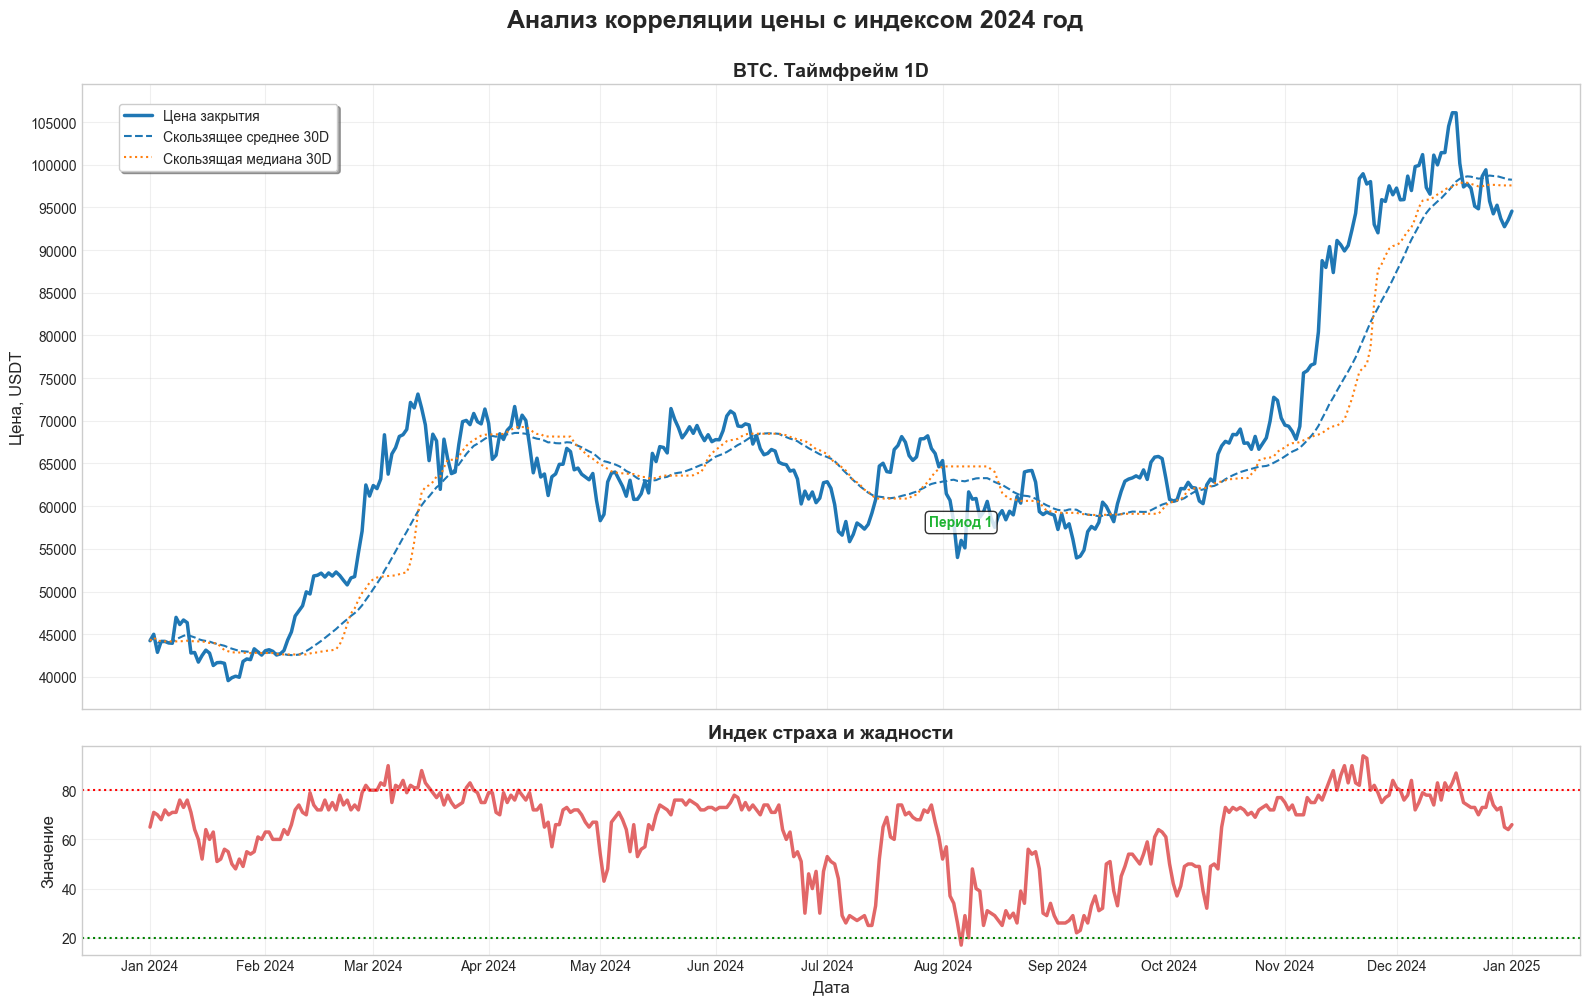

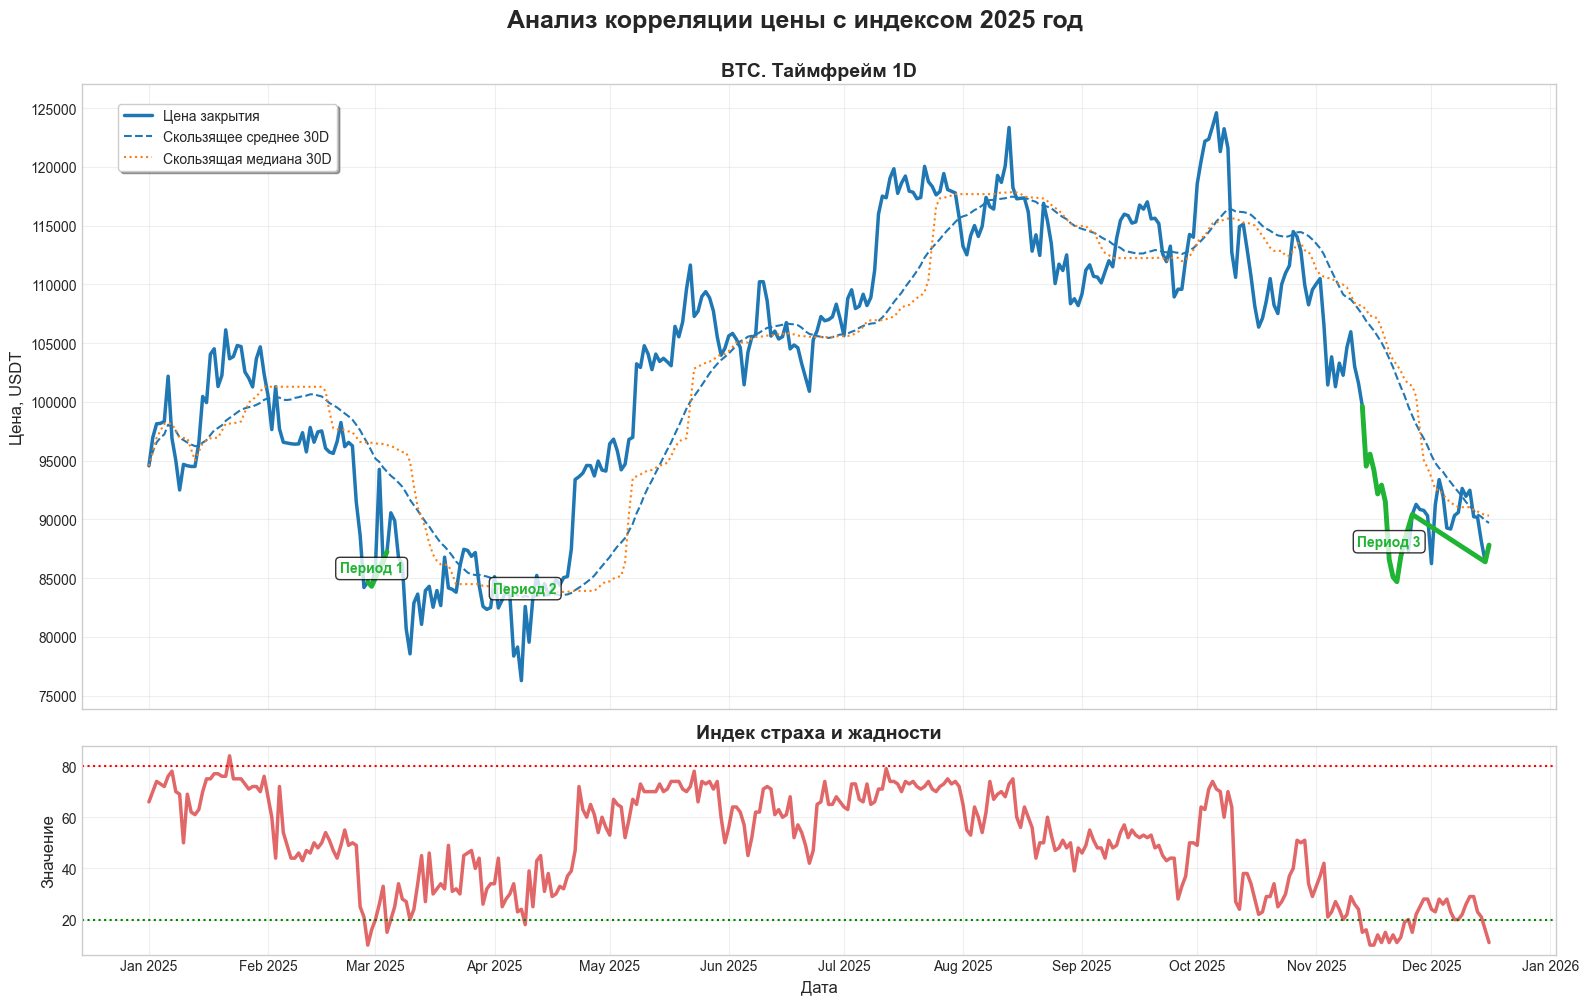

In [13]:
# Строим графики и накладываем периоды низкого индекса <= 20
periods_2024_plot = global_plot(total_2024, index_lines=lines, periods=periods_2024)
periods_2025_plot = global_plot(total_2025, index_lines=lines, periods=periods_2025)


Теперь мы отчетливо видим, что при достижений индекса значений $\leq 20$ цена через досаточно короткий промежуток времени меняет свой тренд на противоположный. Это опровергает нашу изначальную гипотезу.

В связи с этим можно сделать вывод, что такие периоды являются очень хорошими моментами для среднесрочных инвестиций.

<a id='5-1'></a>
## Часть 6.1. Показатель рентабельности инвестиций ROI
Попробуем посчитать, какую доходность может принести Bitcoin через 3 месяца, если мы будем покупать его в периоды экстремально низкого индекса. Для этого рассчитаем возврат на инвестиции (ROI) без привязки к сумме вложенных средств. Будем отталкиваться от того, что мы покупаем 1 монету.

**ROI (Return on Investment — «возврат на инвестиции»)** — ключевой показатель рентабельности вложений. Он демонстрирует, сколько дохода приносит каждый вложенный рубль 
(или другая валюта), и помогает оценить, насколько прибыльным оказался проект или инвестиция.

Формула для расчета ROI:
$$
\text{ROI} = \frac{\text{Текущая стоимость инвестиций - Начальная стоимость инвестиций}}{\text{Начальная стоимость инвестиций}} \times 100\%,\text{где}
$$,
**Текущая стоимость инвестиций** — это рыночная стоимость активов на момент расчёта, включая дивиденды (для акций) или доход от стейкинга (для криптовалют). **Начальная стоимость инвестиций** — сумма, потраченная на покупку активов, плюс комиссии и другие расходы.

<a id='5-2'></a>
## Часть 6.2. Расчет показателя

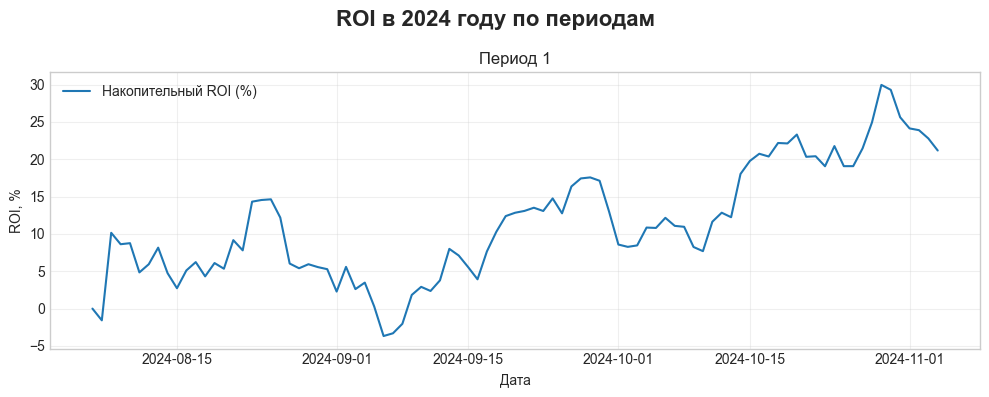

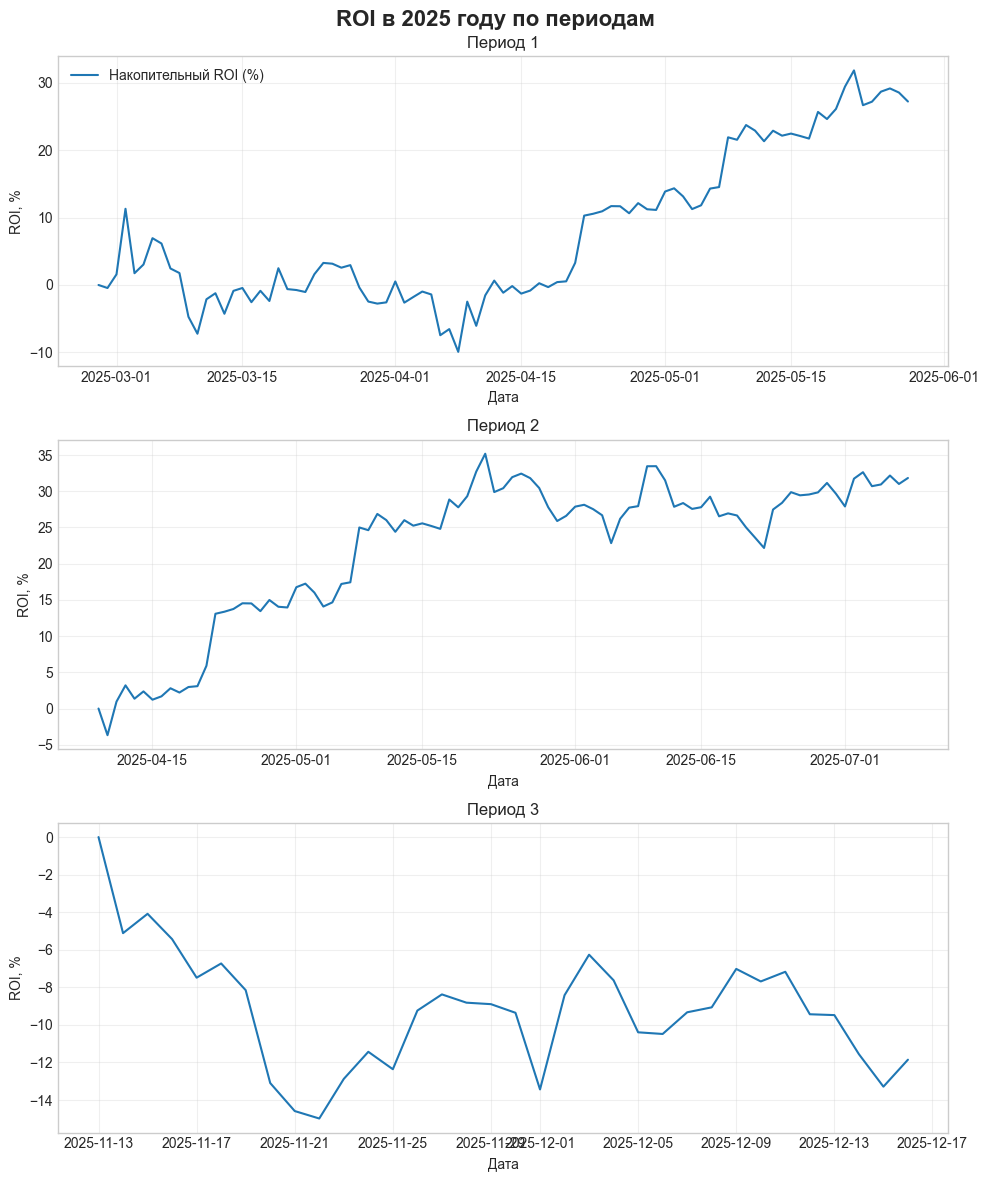

In [14]:
# Посчитаем ROI через 90 дней после начала периодов с низким индексом
def calculate_roi(periods: list, total: pd.DataFrame, period: int = None):
    '''
    Функция берет первый день каждого периода и считает ROI
    Параметры
    periods: list
        Список периодов
    total: pd.DataFrame
        Датафрейм с данными цены и индекса
    period: int
        Период в днях для расчета
    '''
    # Берем первые дни периодов
    start_low_index = pd.concat([
        pd.DataFrame({'period': [i + 1], 'index': period['index'].iloc[[0]]})
        for i, period in enumerate(periods)])
    start_low_total = pd.concat([total, start_low_index], axis=1)
    start_low_total = start_low_total.asfreq('D', method='pad').loc[:, ['close', 'period']]
    
    # Рассчитваем ROI
    n_periods = [i for i in start_low_index['period']]
    roi_per = []
    for i in n_periods:
        start_period = start_low_total.query(f'period == {i}').index.min()
        end_period = start_period + pd.Timedelta(days=period)
        result = start_low_total[start_period:end_period]
        ROI = 100 * (result.close - result.close.iloc[0]) / result.close.iloc[0]
        roi_per.append(ROI)
    
    return roi_per

# Визуализируем полученные данные 
def visual_roi(data: list):
    '''
    Функция визуализирует показатель ROI
    Параметры:
    data: list
        Список данных по roi за периоды
    '''
    fig, axes = plt.subplots(len(data), 1, figsize=(10, len(data) * 4), squeeze=False)
    axes = axes.flatten()

    for i, r in enumerate(data):
        axes[i].plot(r, label='Накопительный ROI (%)')
        axes[i].set_title(f'Период {i + 1}')
        axes[i].set_xlabel('Дата')
        axes[i].set_ylabel('ROI, %')
        axes[i].grid(True, alpha=0.3)

        if i == 0:
            axes[i].legend()

    fig.suptitle(f'ROI в {data[0].index[0].strftime('%Y')} году по периодам',
                fontsize=16,
                fontweight='bold')
    plt.tight_layout()
    plt.show()

roi_2024 = calculate_roi(periods_2024, total_2024, 90)
roi_2025 = calculate_roi(periods_2025, total_2025, 90)
visual_roi_2024 = visual_roi(roi_2024)
visual_roi_2025 = visual_roi(roi_2025)

<a id='5-3'></a>
## Часть 6.2. Анализ результатов
Из графиков мы видим очень интересную ситуацию. Практически во всех случаях, кроме последнего периода 2025 года, у нас наблюдается значительный положительный ROI спустя 3 месяца после покупки актива. Да, важно отметить что 1 и 2 период 2025 года наложились друг на друга из-за небольшого временного разрыва, но это не повлияет на конечный результат.

Итоговый показатель рнетабельности инвестиций через 3 месяца с начала периода за 2024-2025 гг.:
### 2024 год
* 1 период: $ROI \approx 22\%$
### 2025 год
* 1-2 период: $ROI \approx 30\%$
* 3 период: $ROI \approx \ ?$

Касательно последнего отрицательного периода, тут наших данных пока недостаточно, чтобы точно оценить значение показателя. В первом квартале 2026 года можно будет более точно рассчитать данный показавтель с уже новыми данными. 

Интересным остался и тот факт, что период для покупки актива в 2024 году составил всего 1 день. Это может говорить о том, что волатильность на рынке в 2024 году была не такой высокой, как в следующем году. 

<a id='6'></a>
# Часть 7. Выводы

### 1. Краткие итоги

В результате данной работы мы выяснили:
* Индекс страха и жадности на криптовалютном рынке имеет умеренную положительную корреляцию с ценой криптовалюты Bitcoin.
* Убедились с помощью расчета, что корреляция является значимой (p-value < 0.05).
* Выяснили, как периоды экстремально низкого индекса влияют на цену, проверив гипотезу.
* Посчитали показатель рентабельности инвестиций ROI и наглядно убедились в положительной динамике.

### 2. Оценка решения поставленной задачи

Основные задачи были достигнуты в достаточной степени. Частично не была достигнута задача рассчета показателя рентабельности инвестиций. Мы не смогли в полной мере достоверно рассчитать показатель за 3 период 2025 года по причине отсутствия части данных. 

### 3. Значимость и дальнейшее использование результатов

Результаты данной работы могут быть положены в основу алгоритма машинного обучения для принятия решений о покупке/продаже активов на основе показателей индекса страха и жадности. 

Потенциал для дальнейших исследований остается достаточно обширным. Можно попробовать оценить влияние сразу несколько различных индексов на цену, и при хороших результатах это даст более высокую точность для принятия решений при обучении алгоритма машинного обучения.


### 4. Перспективы дальнейших ислледований

В качестве ближайшей перспективы для дальнейшего ислледования можно будет рассмотреть поведение объема торгов в момент экстремальных периодов индекса. Вполне вероятно, что большие объемы смогут подсказать нам моменты ротации капитала на рынке. Также можно попробовать дополнить данные индексом RSI (Relative Strength Index, «индекс относительной силы»), чтобы увидеть зависимость силы текущего тренда в момент экстремальных показателй индекса страха и жадности, найти какие-либо закономерности.

### 5. Общие заключительные тезисы

Данная работа четко дала понять, что хорошими моментами для покупок активов на криптовалютном рынке являются периоды экстремально низкого значения индекса $\leq 20$. Показатель рентабельности инвестиций в такие периоды имеет положительную тенденцию на горизонте 3+ месяцев. 

Ответ на главный вопрос нашего исследования мы получили, что демонстрирует его успешности. 

